# Example: Backdoor adjustment

In [1]:
from typing import Dict, List, Optional, Tuple, Union, TypeVar

import torch
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample, PyroParam
from pyro.contrib.autoname import scope
from pyro.poutine import condition, reparam

import causal_pyro
from causal_pyro.query.do_messenger import do
from causal_pyro.counterfactual.handlers import Factual, MultiWorldCounterfactual, TwinWorldCounterfactual

## Background: systematically adjusting for observed confounding

Suppose we wish to estimate how
effective a particular treatment $T$ is in producing a desired outcome
$Y$. We assume we have observations of patients who have and have not
received treatment, but that we have not conducted a randomized
controlled trial.

Estimating $P(Y|T)$ would not accurately characterize
the effect of the treatment, because this conditional distribution may
reflect confounding from other patient attributes $X$ that affect both
the treatment the patient receives and the effectiveness of the
treatment on the outcome.

For example, $P(Y \mid T = 1)$ may place high
mass on positive health outcomes, but only because younger patients are
both more likely to receive treatment and less likely to experience
negative health outcomes.

## Model: discrete causal Bayesian network

The causal assumptions at work can be encoded as a probabilistic program in Pyro. 

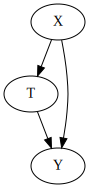

In [2]:
def backdoor_cbn(theta_x, theta_t, theta_y):
    X = pyro.sample("X", dist.Categorical(theta_x))
    T = pyro.sample("T", dist.Categorical(theta_t[..., X, :]))
    Y = pyro.sample("Y", dist.Categorical(theta_y[..., T, X, :]))
    return Y

pyro.render_model(backdoor_cbn, model_args=(torch.rand(2), torch.rand(2, 2), torch.rand(2, 2, 2)))


From this program, an *intervened* version can be
derived, representing experimental conditions for a patient assigned a
certain treatment $T:=t$.

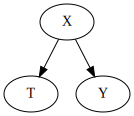

In [3]:
intervened_backdoor_cbn = do(backdoor_cbn, {"T": 0})

pyro.render_model(intervened_backdoor_cbn, model_args=(torch.rand(2), torch.rand(2, 2), torch.rand(2, 2, 2)))

## Query: average treatment effect (ATE)

Under these assumptions, we wish to compute the *average treatment
effect*, $ATE = \mathbb{E}[Y=1|do(T=1)] - \mathbb{E}[Y=1|do(T=0)]$. The
`do` notation indicates that the expectations are taken according to
*intervened* versions of the model, with $T$ set to a particular value.
Note that this is different from conditioning on $T$ in the original
`causal_model`, which assumes $X$ and $T$ are dependent.

As in all of our examples in this paper, the estimand of interest (in
this case, the ATE) can be expressed as a posterior expectation in an
*expanded* probabilistic program. (For the simple example in this
section, this is a standard result, see e.g. {cite:p}`pearl` and
{cite:p}`lattimore_2019`.) 

Suppose we have a set of measurements
$Y^{(i)}, T^{(i)}, X^{(i)}$ from an observational population
distribution $P(Y, T, X)$. The following probabilistic program encodes a
joint distribution over $\theta$, samples from the causal model, and
hypothetical data corresponding to possible experimental outcomes if
random patients were assigned treatment (1) or no treatment (0).
The ATE is the expected return value of the program after conditioning
our uncertainty of the true model parameters $\theta$ on the measured
observational data.

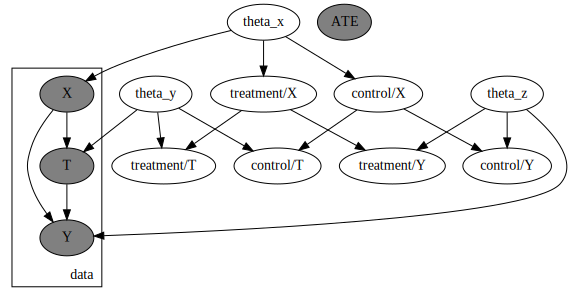

In [4]:
class BayesianBackdoorATE(PyroModule):
    def __init__(self):
        super().__init__()

    @PyroSample
    def theta_x(self):
        return dist.Dirichlet(torch.ones(2))

    @PyroSample
    def theta_y(self):
        return dist.Dirichlet(torch.ones(2, 2))

    @PyroSample
    def theta_z(self):
        return dist.Dirichlet(torch.ones(2, 2, 2))

    def forward(self, x, t, y):
        theta_x, theta_y, theta_z = self.theta_x, self.theta_y, self.theta_z

        with pyro.plate("data", x.shape[0], dim=-1):
            Y_obs = condition(data={"X": x, "T": t, "Y": y})(backdoor_cbn)(
                theta_x, theta_y, theta_z)

        with pyro.contrib.autoname.scope(prefix="treatment"):
            Y_treatment = do(actions={"treatment/T": 1})(backdoor_cbn)(
                theta_x, theta_y, theta_z)

        with pyro.contrib.autoname.scope(prefix="control"):
            Y_control = do(actions={"control/T": 0})(backdoor_cbn)(
                theta_x, theta_y, theta_z)

        ATE = pyro.deterministic("ATE", Y_treatment - Y_control)
        return ATE


x_obs, t_obs, y_obs = torch.randint(2, (100,)), torch.randint(2, (100,)), torch.randint(2, (100,))

bayesian_backdoor_ate = BayesianBackdoorATE()
pyro.render_model(bayesian_backdoor_ate, model_args=(x_obs, t_obs, y_obs))

### A different approach

In [7]:
# Not working
# class BayesianBackdoorSCM(BayesianBackdoorATE):

#     def forward(self, x, t, y):

#         extended_model = do(actions={"T": 1. - t})(
#             pyro.plate("data", x.shape[0], dim=-1)(
#                 MultiWorldCounterfactual(-2)(
#                     condition(data={"X": x, "T": t, "Y": y})(
#                         reparam(config=pyro.infer.reparam.strategies.AutoReparam())(
#                             backdoor_cbn)))))
                        
#         Ys = extended_model(self.theta_x, self.theta_y, self.theta_z)

#         ATE = pyro.deterministic("ATE", torch.sum(Ys[..., 1, :] - Ys[..., 0, :], dim=-1) / x.shape[0])
#         return ATE

# bayesian_backdoor_ate_scm = BayesianBackdoorSCM()
# pyro.render_model(bayesian_backdoor_ate_scm, model_args=(x_obs, t_obs, y_obs))

# References

```{bibliography}
:filter: docname in docnames
```